In [41]:
import glob
import os
import omegaconf

import pandas as pd
import numpy as np
import random

import logging

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns


logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)


In [42]:
path_champollion = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/participants.csv"
embeddings_subpath = "ukb_random_embeddings/full_embeddings.csv"
output_filename = f"{path_champollion}/summary/SexSmallBrain_ukb_without_residualization.csv"
label = "Sex"
max_iter = 2000
cv = 3

In [43]:
participants = pd.read_csv(participants_file, index_col=0)


In [44]:
participants = participants[participants.isBigBrain==0]

In [45]:
participants = participants[["Sex", "BrainVolumeFreeSurfer_mm3"]]

In [46]:
def closest_point(point, points):
    """ Find closest point from a list of points. """
    return np.argsort((points-point)**2)[:10]

In [47]:
participants

,Sex,BrainVolumeFreeSurfer_mm3
participant_id,,
sub-1188492,0,997615.0
sub-2348409,0,1002614.0
sub-2214448,1,1012144.0
sub-5790117,0,1007438.0
sub-3794733,0,964232.0
...,...,...
sub-1734788,0,1029931.0
sub-1673986,0,1000852.0
sub-5224110,0,997299.0


In [48]:
females = participants[participants.Sex==0].copy()
males = participants[participants.Sex==1].copy()

females["chosen"] = 0
for one_male in males.iloc[:,1]:
    chosen_rows = closest_point(one_male, females.iloc[:,1])
    for chosen_row in chosen_rows:
        if females.iloc[chosen_row, 2] == 0:
            females.iloc[chosen_row, 2] = 1
            break

participants = pd.concat([males, females[females.chosen==1][["Sex", "BrainVolumeFreeSurfer_mm3"]]])

In [49]:
# participants[participants.Sex==0]["BrainVolumeFreeSurfer_mm3"].hist(bins=100)

In [50]:
# participants[participants.Sex==1]["BrainVolumeFreeSurfer_mm3"].hist(bins=100)

In [51]:
participants = participants[[label]].dropna()

array([[<Axes: title={'center': 'Sex'}>]], dtype=object)

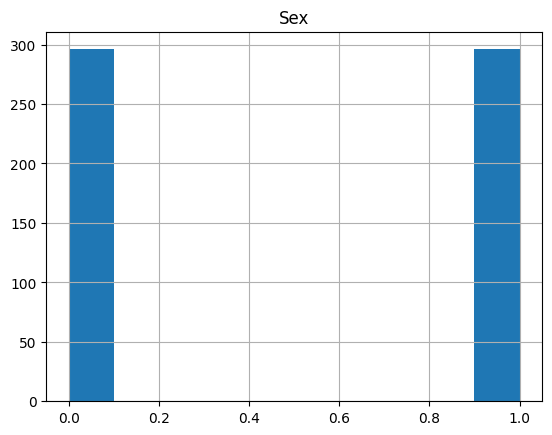

In [52]:
participants.hist()

In [53]:
def is_it_a_file(sub_dir):
    if os.path.isdir(sub_dir):
        return False
    else:
        logging.debug(f"{sub_dir} is a file. Continue.")
        return True
    

def is_folder_a_model(sub_dir):
    if os.path.exists(sub_dir+'/.hydra/config.yaml'):
        return True
    else:
        logging.debug(f"\n{sub_dir} not associated to a model. Continue")
        return False

def get_model_paths(dir_path, result = None):
    """Recursively gets all models included in dir_path"""
    if result is None:  # create a new result if no intermediate was given
        result = [] 
    for name in os.listdir(dir_path):
        sub_dir = dir_path + '/' + name
        # checks if directory
        if is_it_a_file(sub_dir):
            pass
        elif not is_folder_a_model(sub_dir):
            result.extend(get_model_paths(sub_dir))
        else:
            result.append(sub_dir)
    return result

In [54]:
model_paths = get_model_paths(path_champollion)

In [55]:
model_paths[:5]

['/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1']

In [56]:
def compute(model_path):
    # Gets region name
    cfg = omegaconf.OmegaConf.load(model_path+'/.hydra/config.yaml')
    region = cfg['dataset'][next(iter(cfg['dataset']))]['crop_dir'].split('/')[-3]
    side = next(iter(cfg['dataset'])).split('_')[-1]
    region = region + '_' + side
    model_name = model_path.split('/')[-1]
    region_path = '/'.join(model_path.split('/')[-2:])
    print(f"Treating {region}: {region_path} : {model_path}")
    
    # Loads embeddings
    embeddings = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
    merged = participants[[label]].merge(embeddings, left_index=True, right_index=True)
    
    # Classifies
    X = merged.drop([label], axis=1)
    Y = merged[[label]]
    scaler = StandardScaler()
    X[X.columns] = scaler.fit_transform(X)
    df2 = X.copy()

    # Makes OLS
    df2 = sm.add_constant(df2)
    model = sm.OLS(Y[label], df2)
    results = model.fit()
    f_value = results.fvalue
    p_value = results.f_pvalue
    
    # Gets result
    # roc_auc = roc_auc_score(Y, proba_pred[:,1])
    print(f_value)
    
    # Returns result
    return (region, f_value, p_value, model_name, region_path, model_path)

In [57]:
result = []
for model_path in model_paths:
    result.append(compute(model_path))

Treating S.C.-sylv._left: SC-sylv_left/11-43-38_2 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2
1.8084507378207861
Treating S.C.-sylv._left: SC-sylv_left/14-00-57_116 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116
1.5967073688317768
Treating S.F.inter.-S.F.sup._left: SFinter-SFsup_left/09-33-02_0 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0
0.9445586677675467
Treating S.T.i.-S.T.s.-S.T.pol._right: STi-STs-STpol_right/20-15-00_117 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117
1.3524431889356086
Treating F.Coll.-S.Rh._right: FColl-SRh_right/09-45-57_1 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1
1.669469773839262
Treating S.C.-sylv._right: SC-sylv_right/11-43-38_3 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_right/11-43-38

In [58]:
df = pd.DataFrame(result, columns=['region', 'f_value', 'p_value', 'model_name', 'region_path', 'model_path'])

In [59]:
df

,region,f_value,p_value,model_name,region_path,model_path
0,S.C.-sylv._left,1.808451,0.000012,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...
1,S.C.-sylv._left,1.596707,0.000406,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...
2,S.F.inter.-S.F.sup._left,0.944559,0.664356,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...
3,S.T.i.-S.T.s.-S.T.pol._right,1.352443,0.014889,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...
4,F.Coll.-S.Rh._right,1.669470,0.000126,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...
...,...,...,...,...,...,...
72,S.F.inter.-S.F.sup._right,1.268451,0.043252,09-33-02_1,SFinter-SFsup_right/09-33-02_1,/neurospin/dico/data/deep_folding/current/mode...
73,S.T.s._left,1.384166,0.009685,11-43-38_0,STs_left/11-43-38_0,/neurospin/dico/data/deep_folding/current/mode...
74,F.C.M.post.-S.p.C._right,1.638104,0.000209,15-09-24_1,FCMpost-SpC_right/15-09-24_1,/neurospin/dico/data/deep_folding/current/mode...
75,ORBITAL_right,1.398817,0.007904,15-53-41_191,ORBITAL_right/15-53-41_191,/neurospin/dico/data/deep_folding/current/mode...


In [60]:
df['side'] = df['region'].str.split('_').str[-1]

In [61]:
def plot_horizontal(res, region_name, ax, f_value, p_value, f2_value, visible, title):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    
    res = res.sort_values(by=f_value, ascending=True)

    # ax.errorbar(res[AUC_name], res[region_name], res[std_auc_name], fmt='s', color='black')
    # ax.scatter(res[AUC_name], res[region_name], marker='s', color='black')
    ax.axvline(x=-np.log10(0.05/76), color='black', linestyle='-')
    ax.barh(res[region_name], -np.log10(res[f2_value]), fill=True, color='lightgray')
    ax.errorbar(res[f_value], res[region_name], xerr=0, fmt='s', color='black')
    # if visible:
    #     ax.set_ylabel("AUC ensemble")
    # else:
    #     ax.get_yaxis().set_ticks([])
    # ax.set_xlim((0.3, 1.0))
    ax.set_title(title)


In [62]:
df.sort_values(by="f_value", ascending=False)

,region,f_value,p_value,model_name,region_path,model_path,side
16,F.Coll.-S.Rh._left,2.341322,1.141054e-09,09-45-57_0,FColl-SRh_left/09-45-57_0,/neurospin/dico/data/deep_folding/current/mode...,left
11,S.F.inf.-BROCA-S.Pe.C.inf._right,2.096710,8.392021e-08,12-25-50_1,SFinf-BROCA-SPeCinf_right/12-25-50_1,/neurospin/dico/data/deep_folding/current/mode...,right
22,S.Or.-S.Olf._right,1.993639,5.091053e-07,18-00-16_1,SOr-SOlf_right/18-00-16_1,/neurospin/dico/data/deep_folding/current/mode...,right
31,Sc.Cal.-S.Li._left,1.929286,1.557040e-06,09-28-12_0,ScCal-SLi_left/09-28-12_0,/neurospin/dico/data/deep_folding/current/mode...,left
59,F.C.L.p.-subsc.-F.C.L.a.-INSULA._left,1.896251,2.754932e-06,18-59-14_0,FCLp-subsc-FCLa-INSULA_left/18-59-14_0,/neurospin/dico/data/deep_folding/current/mode...,left
...,...,...,...,...,...,...,...
25,CINGULATE_left,1.057833,3.438584e-01,16-58-04_1,2024-07-16/16-58-04_1,/neurospin/dico/data/deep_folding/current/mode...,left
52,S.F.marginal-S.F.inf.ant._left,1.015576,4.581360e-01,17-49-19_0,SFmarginal-SFinfant_left/17-49-19_0,/neurospin/dico/data/deep_folding/current/mode...,left
24,CINGULATE_left,1.009145,4.765522e-01,17-13-32_1,2024-07-15/17-13-32_1,/neurospin/dico/data/deep_folding/current/mode...,left
58,F.I.P._right,0.990676,5.302746e-01,20-16-33_3,FIP_right/20-16-33_3,/neurospin/dico/data/deep_folding/current/mode...,right


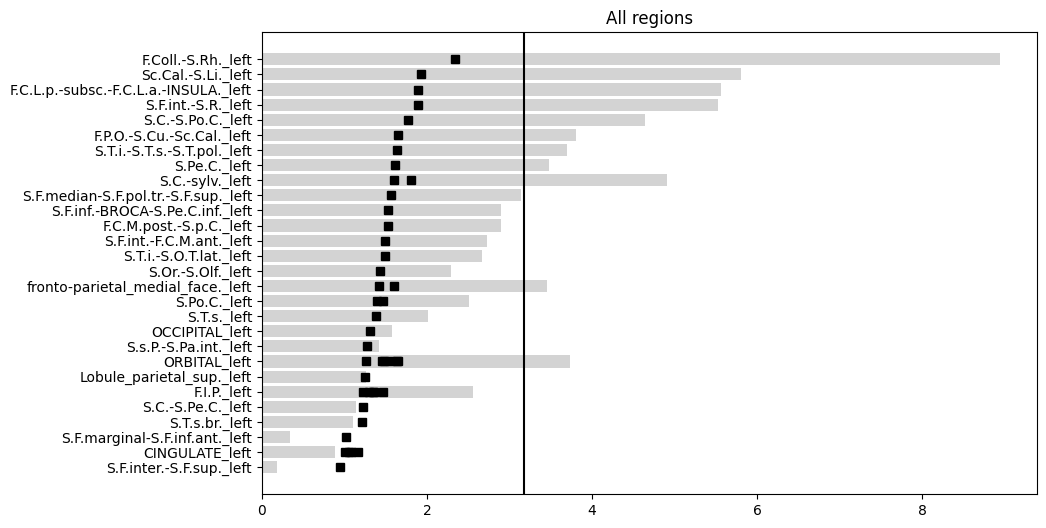

In [63]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='left'], "region", ax, "f_value", "f_value", "p_value",  True, "All regions")
plt.show()

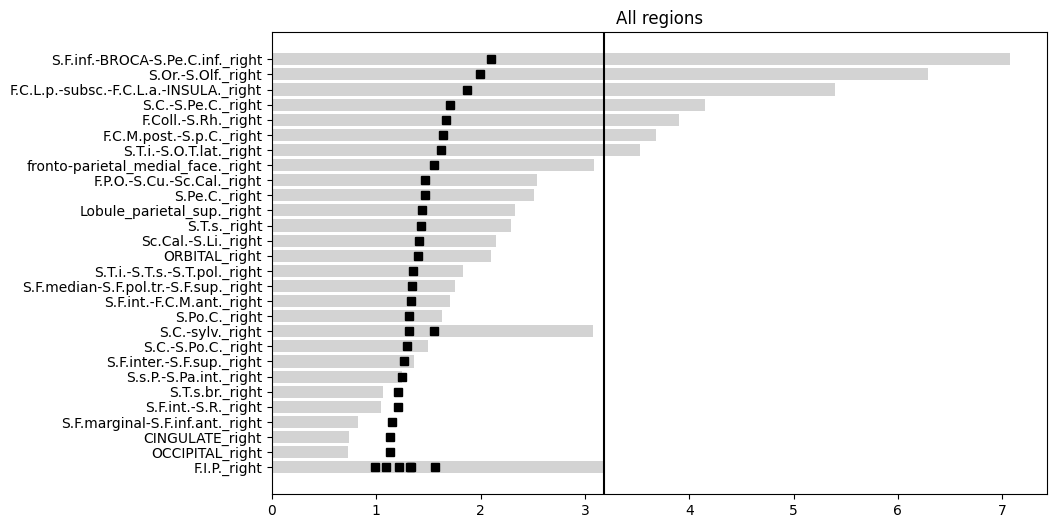

In [64]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='right'], "region", ax, "f_value", "p_value", "p_value",  True, "All regions")
plt.show()

In [65]:
df

,region,f_value,p_value,model_name,region_path,model_path,side
0,S.C.-sylv._left,1.808451,0.000012,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...,left
1,S.C.-sylv._left,1.596707,0.000406,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...,left
2,S.F.inter.-S.F.sup._left,0.944559,0.664356,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...,left
3,S.T.i.-S.T.s.-S.T.pol._right,1.352443,0.014889,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...,right
4,F.Coll.-S.Rh._right,1.669470,0.000126,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...,right
...,...,...,...,...,...,...,...
72,S.F.inter.-S.F.sup._right,1.268451,0.043252,09-33-02_1,SFinter-SFsup_right/09-33-02_1,/neurospin/dico/data/deep_folding/current/mode...,right
73,S.T.s._left,1.384166,0.009685,11-43-38_0,STs_left/11-43-38_0,/neurospin/dico/data/deep_folding/current/mode...,left
74,F.C.M.post.-S.p.C._right,1.638104,0.000209,15-09-24_1,FCMpost-SpC_right/15-09-24_1,/neurospin/dico/data/deep_folding/current/mode...,right
75,ORBITAL_right,1.398817,0.007904,15-53-41_191,ORBITAL_right/15-53-41_191,/neurospin/dico/data/deep_folding/current/mode...,right


In [66]:
# df.to_csv(output_filename)